hyper parameter探索実行
出力結果はrunごとにフォルダ分けして保存
TensorBoardで結果確認可能

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls -l '/content/drive/MyDrive/Colab Notebooks/NFFA-SEM/outputs/20250430_024232_lr0.0001_bs32'

total 43790
-rw------- 1 root root 44790466 Apr 30 02:44 model.pth
drwx------ 2 root root     4096 Apr 30 02:42 tensorboard
-rw------- 1 root root    24299 Apr 30 02:44 training_accuracy_curve.png
-rw------- 1 root root    19959 Apr 30 02:44 training_loss_curve.png
-rw------- 1 root root      956 Apr 30 02:44 train.log


## Confusion matrix

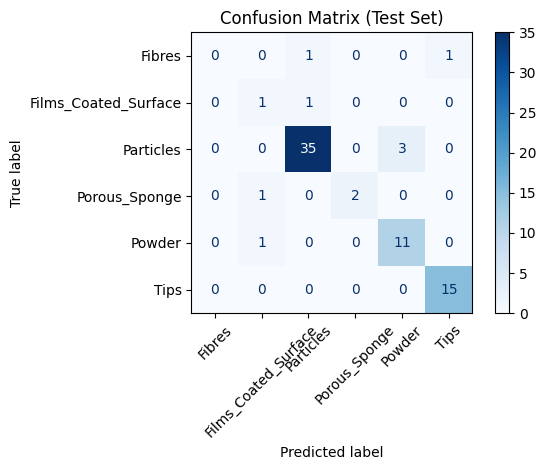


Classification Report:
                      precision    recall  f1-score   support

              Fibres       0.00      0.00      0.00         2
Films_Coated_Surface       0.33      0.50      0.40         2
           Particles       0.95      0.92      0.93        38
       Porous_Sponge       1.00      0.67      0.80         3
              Powder       0.79      0.92      0.85        12
                Tips       0.94      1.00      0.97        15

            accuracy                           0.89        72
           macro avg       0.67      0.67      0.66        72
        weighted avg       0.88      0.89      0.88        72



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# === Configuration ===
data_dir = '/content/drive/MyDrive/Colab Notebooks/NFFA-SEM/data/processed'
model_path = '/content/drive/MyDrive/Colab Notebooks/NFFA-SEM/outputs/20250430_024232_lr0.0001_bs32/model.pth'
subset_ratio = 0.1
input_size = (224, 224)
batch_size = 32
random_seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Transform ===
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])

# === Load full dataset ===
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes

# === Apply subset ratio (e.g., 10%) ===
subset_size = int(len(full_dataset) * subset_ratio)
subset, _ = random_split(
    full_dataset,
    [subset_size, len(full_dataset) - subset_size],
    generator=torch.Generator().manual_seed(random_seed)
)

# === Split into train/val/test (8:1:1) ===
train_size = int(0.8 * len(subset))
val_size = int(0.1 * len(subset))
test_size = len(subset) - train_size - val_size

_, _, test_set = random_split(
    subset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(random_seed)
)

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# === Load model ===
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# === Inference ===
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test Set)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Classification Report ===
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

In [33]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Subset, random_split

# === Config ===
data_dir = '/content/drive/MyDrive/Colab Notebooks/NFFA-SEM/data/processed'
model_path = '/content/drive/MyDrive/Colab Notebooks/NFFA-SEM/outputs/20250430_024232_lr0.0001_bs32/model.pth'
output_dir = '/content/outputs/20250430_024232_lr0.0001_bs32/misclassified_images'
subset_ratio = 0.1
batch_size = 32
input_size = (224, 224)
random_seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Transform ===
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])

# === Load full dataset ===
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes

# === Apply subset ratio (e.g., 10%) ===
subset_size = int(len(full_dataset) * subset_ratio)
subset, _ = random_split(
    full_dataset,
    [subset_size, len(full_dataset) - subset_size],
    generator=torch.Generator().manual_seed(random_seed)
)

# === Split into train/val/test (8:1:1) ===
train_size = int(0.8 * len(subset))
val_size = int(0.1 * len(subset))
test_size = len(subset) - train_size - val_size

_, _, test_set = random_split(
    subset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(random_seed)
)

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# === Load model ===
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# === Save misclassified images ===
os.makedirs(output_dir, exist_ok=True)
counter = 0

# === Run inference and collect results ===
correct = []
misclassified = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(inputs.size(0)):
            img = to_pil_image(inputs[i].cpu())
            pred = preds[i].item()
            true = labels[i].item()
            sample = (img, true, pred)
            if pred == true:
                correct.append(sample)
            else:
                misclassified.append(sample)

# === Function to plot grid ===
from collections import defaultdict

def plot_image_grid(data_list, title, class_names, cols=5, max_items=100):
    """
    Display a grid of PIL images with sorted class name order.
    Each image shows true label, or true → pred if misclassified.
    """
    if len(data_list) == 0:
        print(f"No data to show for: {title}")
        return

    # Sort by true class index to order by class name
    data_list = sorted(data_list, key=lambda x: x[1])

    n = min(len(data_list), max_items)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten() if rows > 1 else [axes]

    for idx in range(rows * cols):
        ax = axes[idx]
        ax.axis("off")

        if idx < n:
            img, true_idx, pred_idx = data_list[idx]
            label = class_names[true_idx]
            if true_idx != pred_idx:
                label = f"{class_names[true_idx]} → {class_names[pred_idx]}"
            ax.imshow(img)
            ax.set_title(label, fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
# === Show result grids ===
plot_image_grid(correct, "Correctly Classified Samples", class_names)
plot_image_grid(misclassified, "Misclassified Samples", class_names)

Output hidden; open in https://colab.research.google.com to view.